In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
import tensorflow_addons as tfa

In [2]:
# Check if a GPU is available and set GPU device accordingly
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    print ("Found GPU")

Found GPU


In [9]:
# split the string column into separate features
def split_string2(text):
    features = text.split(',')
    for i in range(len(features)):
        if i == 0 or i == 1:
            if features[i] != 'nan':
                timestamp = datetime.strptime(features[i], '%Y-%m-%d %H:%M:%S%z')
                features[i] = timestamp.timestamp()
            else:
                features[i] = datetime(2000, 1, 1, 0, 0, 0, tzinfo=None).timestamp()
        else:
            features[i] = float(features[i])
    return features 

# Run Feed Forward Network first before running below code

In [3]:
from datetime import datetime

# Function to process a single chunk of data
def process_chunk(chunk):
    # Replace "Legit" with 1 and "Dodgy" with 0 in 'Label' column
    chunk['encoded_label'] = chunk['Label'].replace({'Legit': 1, 'Dodgy': 0})
    
    # Get a list of column names to concatenate
    cols_to_concat = [col for col in chunk.columns if col not in ['Label', 'encoded_label']]
    # Concatenate the values in each row of the specified columns, and store the result in a new column called 'concatenated_values'
    chunk['text'] = chunk[cols_to_concat].apply(lambda row: ','.join(str(val) for val in row), axis=1)

    return chunk[['text', 'encoded_label']]

# Read and process the data in chunks
chunksize = 1000000  # Adjust this value based on your available memory
processed_data = []

In [4]:
# Combine relevant columns into a single text column
with pd.read_csv("./output/validation.csv", chunksize=chunksize) as reader:
    i = 0
    for chunk in reader:
        print ("----------------Processing chunk: ", i ,"-----------------------")
        processed_chunk = process_chunk(chunk)
        processed_data.append(processed_chunk)
        i += 1

print ("Finish text column generation, combining chunk....")
# Combine all processed chunks into a single DataFrame
processed_data = pd.concat(processed_data, ignore_index=True)
#     str(new_df['Account Type']) + ' ' + str(new_df['Contract Type']) 
# + ' ' + str(new_df['Entity']) + ' ' + str(new_df['Tags'])+ ' '  +\
#     new_df['value_frame'] + ' ' + new_df['gas_frame'] + ' ' + new_df['gas_price_frame'] + ' ' + new_df['input_frame']+ ' '  +\
#     new_df['receipt_cumulative_gas_used_frame'] + ' ' + new_df['receipt_gas_used_frame'] + new_df['receipt_contract_address_frame']+ ' '  +\
#     new_df['block_timestamp_frame'] + ' ' + new_df['block_number_frame'] + ' ' + new_df['max_fee_per_gas_frame'] + ' ' +\
#     new_df['max_priority_fee_per_gas_frame'] + new_df['transaction_type_frame'] + ' ' + new_df['address_frame']+ ' '  +\
#     new_df['eth_balance_frame'] + ' ' + new_df['receipt_effective_gas_price_frame']

processed_data

----------------Processing chunk:  0 -----------------------
----------------Processing chunk:  1 -----------------------
----------------Processing chunk:  2 -----------------------
----------------Processing chunk:  3 -----------------------
----------------Processing chunk:  4 -----------------------
----------------Processing chunk:  5 -----------------------
----------------Processing chunk:  6 -----------------------
----------------Processing chunk:  7 -----------------------
----------------Processing chunk:  8 -----------------------
----------------Processing chunk:  9 -----------------------
----------------Processing chunk:  10 -----------------------
----------------Processing chunk:  11 -----------------------
----------------Processing chunk:  12 -----------------------
----------------Processing chunk:  13 -----------------------
----------------Processing chunk:  14 -----------------------
----------------Processing chunk:  15 -----------------------
----------------Pr

,text,encoded_label
0,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
1,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
2,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
3,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
4,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
...,...,...
16326932,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326933,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326934,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326935,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1


In [11]:
features = processed_data['text'].apply(split_string2)
processed_data['text'] = features
processed_data

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [6]:
# Check for NaN and infinite values
if processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert it to float32 for Random Forest library
from sklearn.preprocessing import MinMaxScaler

# Convert the "text" column to a numpy array
text_array = np.array(list(processed_data["text"]))

# Scale down the values in the array to the range [0, 1]
scaler = MinMaxScaler()
text_array_scaled = scaler.fit_transform(text_array)

# Cast the scaled array to the float32 data type
text_array_scaled = text_array_scaled.astype(np.float32)

# Create a new dataframe with the scaled "text" column and the original "encoded_label" column
new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': processed_data['encoded_label']})

# Replace the original "processed_data" dataframe with the new dataframe
processed_data = new_df

processed_data

,text,encoded_label
0,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
1,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
2,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
3,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
4,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
...,...,...
16326932,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326933,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326934,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326935,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1


In [7]:
# # We have 22 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
# column_names = [f'feature_{i}' for i in range(0, 22)]

# # Create a new DataFrame with separate columns
# encoded_labels = processed_data["encoded_label"]
# processed_data_expanded = pd.DataFrame(processed_data['text'].tolist(), columns=column_names, index=processed_data.index)
# processed_data_expanded.dropna(inplace=True)
# processed_data_expanded["encoded_labels"] = encoded_labels

# processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
1,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
2,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
3,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
4,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16326932,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326933,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326934,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326935,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1


In [7]:
# Define the features and the target
X_val = processed_data.drop('encoded_label', axis=1)
y_val = processed_data['encoded_label']

In [13]:
X_val

,text
0,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0...."
1,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0...."
2,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0...."
3,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0...."
4,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0...."
...,...
16326932,"[0.36666092, 0.99976754, 0.0005824536, 5.66271..."
16326933,"[0.36666092, 0.99976754, 0.0005824536, 5.66271..."
16326934,"[0.36666092, 0.99976754, 0.0005824536, 5.66271..."
16326935,"[0.36666092, 0.99976754, 0.0005824536, 5.66271..."


# Feed Forward Neural Network

In [ ]:
# val_df = pd.read_csv('./data/Kaggle/kaggle_validation.csv', index_col=None, header=0)
# len(val_df['address'].unique())

In [ ]:
# # load your dataset
# df = processed_data

# len(df['text'][0])

Using non-balance data to match cost-sensitive learning

In [5]:
# train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
train_processed_data = pd.read_csv('./output/one_text_col_data.csv')

train_processed_data

,text,encoded_label
0,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
1,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
2,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
3,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
4,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
...,...,...
16333467,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333468,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333469,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333470,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1


In [6]:
# one_text_col_data
features = train_processed_data['text'].apply(split_string2)
train_processed_data['text'] = features
train_processed_data

,text,encoded_label
0,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
1,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
2,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
3,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
4,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
...,...,...
16333467,"[1525186022.0, 1682542355.0, 2612.0, 2.0562149...",1
16333468,"[1525186022.0, 1682542355.0, 2612.0, 2.0562149...",1
16333469,"[1525186022.0, 1682542355.0, 2612.0, 2.0562149...",1
16333470,"[1525186022.0, 1682542355.0, 2612.0, 2.0562149...",1


In [7]:
# Check for NaN and infinite values
if train_processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert it to float32 for Random Forest library
from sklearn.preprocessing import MinMaxScaler

# Convert the "text" column to a numpy array
text_array = np.array(list(train_processed_data["text"]))

# Scale down the values in the array to the range [0, 1]
scaler = MinMaxScaler()
text_array_scaled = scaler.fit_transform(text_array)

# Cast the scaled array to the float32 data type
text_array_scaled = text_array_scaled.astype(np.float32)

# Create a new dataframe with the scaled "text" column and the original "encoded_label" column
new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': train_processed_data['encoded_label']})

# Replace the original "processed_data" dataframe with the new dataframe
train_processed_data = new_df
train_processed_data

,text,encoded_label
0,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
1,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
2,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
3,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
4,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
...,...,...
16333467,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1
16333468,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1
16333469,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1
16333470,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1


In [14]:
# # We have 22 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
# train_column_names = [f'feature_{i}' for i in range(0, 22)]

# # Create a new DataFrame with separate columns
# train_encoded_labels = train_processed_data["encoded_label"]
# train_processed_data_expanded = pd.DataFrame(train_processed_data['text'].tolist(), columns=train_column_names, index=train_processed_data.index)
# train_processed_data_expanded.dropna(inplace=True)
# train_processed_data_expanded["encoded_labels"] = train_encoded_labels

# train_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
1,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
2,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
3,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
4,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16333467,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333468,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333469,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333470,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1


In [10]:
# # split the string column into separate features
# def split_string(text):
#     # Clean up the string by removing unnecessary characters
#     string = text.replace('[', '').replace(']', '').replace('\n', '')

#     # Split the string by spaces
#     elements = string.split()

#     # Convert each element to a float and create a numpy array
#     array = np.array([float(element) for element in elements])
#     return array 

# # processed_data = processed_data['text'].astype(np.float32)
# features = train_processed_data['text'].apply(split_string)
# train_processed_data['text'] = features
# train_processed_data

,text,encoded_label
0,"[1.0, 0.10309278, 9.8356452e-07, 4.5109897e-05...",1
1,"[1.0, 0.089347079, 1.3165391e-07, 0.0029643648...",1
2,"[1.0, 0.34707904, 6.1747514e-08, 0.0062580747,...",1
3,"[1.0, 0.68041235, 1.2499875e-05, 0.00018043959...",0
4,"[1.0, 0.68041235, 7.18e-06, 0.00018043959, 0.8...",0
...,...,...
14111707,"[0.0, 0.8213059, 0.0, 0.0079964, 0.9708847, 0....",1
14111708,"[1.0, 0.089347079, 2.3273805e-07, 0.0029643648...",1
14111709,"[1.0, 0.34707904, 1.2379381e-07, 0.0062580747,...",1
14111710,"[1.0, 0.94845361, 4.0942348e-07, 0.0, 0.761951...",1


In [8]:
from sklearn.utils import class_weight

df = train_processed_data

In [9]:
df

,text,encoded_label
0,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
1,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
2,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
3,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
4,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
...,...,...
16333467,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1
16333468,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1
16333469,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1
16333470,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1


In [10]:
# prepare datasets
X = df.drop('encoded_label', axis=1)
y = df['encoded_label']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 26.2417750804317, 1: 0.5097118399651485}

In [11]:
# reshape input to be [samples, time steps, features]
# X_train = X_train.reshape(-1, 8)
# X_test = X_test.reshape(-1, 8)

X_train.shape

(13066777, 1)

In [12]:
X_train

,text
15896907,"[0.0071405405, 0.99964225, 0.54753876, 0.00265..."
8049081,"[0.30465916, 0.9198381, 1.0, 1.0159503e-06, 0...."
15393905,"[0.0071405405, 0.99964225, 0.54753876, 0.00265..."
15539025,"[0.0071405405, 0.99964225, 0.54753876, 0.00265..."
14569267,"[0.0071405405, 0.99964225, 0.54753876, 0.00265..."
...,...
6550634,"[0.30465916, 0.9198381, 1.0, 1.0159503e-06, 0...."
16094478,"[0.0071405405, 0.99964225, 0.54753876, 0.00265..."
6423388,"[0.30465916, 0.9198381, 1.0, 1.0159503e-06, 0...."
15351219,"[0.0071405405, 0.99964225, 0.54753876, 0.00265..."


In [11]:
X_train_array = np.stack(X_train['text'].values)
X_test_array = np.stack(X_test['text'].values)
# assuming X_train, X_test, y_train, y_test are your NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_array, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_array, y_test))

# shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
test_dataset = test_dataset.batch(128)

In [23]:
class EvaluateAndEarlyStop(Callback):
    def __init__(self, patience_limit=3):
        super().__init__()
        self.patience_limit = patience_limit
        self.best_loss = float('inf')  # Initialize best loss as infinity
        self.best_precision = 0
        self.patience_counter = 0  # Counter to keep track of non-improvement steps
    
    def on_train_batch_end(self, batch, logs=None):
        if batch % 10000 == 0:  # Perform the evaluation at every 1000th batch
            if self.model.stop_training != True:
                print (self.model.evaluate(X_test, y_test, verbose=0))
                test_loss, test_acc, test_precision, test_recall = self.model.evaluate(X_test, y_test, verbose=0)
                print('\nAfter batch {}, Validation loss: {}, precision: {}\n'.format(batch, test_loss, test_precision))

                # Check if current loss is better than the best observed so far
                if test_loss < self.best_loss and self.best_precision < test_precision:
                    self.best_loss = test_loss
                    self.best_precision = test_precision
                    self.patience_counter = 0  # Reset the counter
                else:
                    print ('Increase Counter: ', self.patience_counter)
                    self.patience_counter += 1

                # If patience limit is reached, stop the training
                if self.patience_counter >= self.patience_limit:
                    self.model.stop_training = True
                    print('Early stopping due to non-improvement in validation loss.')

In [17]:
# define some parameters
max_features = 3202  # this should be set to the number of unique Ethereum addresses in train dataset
embedding_dim = 22

# define the model
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=22))
model.add(Flatten())

# increased neurons, added regularization, batch normalization and dropout
# Note: Performance for trainable number of neurons on local machine
#------- 8192 with 3 Dense layers: 0.57 acc, recall, 0.99 prec and f1 for 1h10 hours per epoch
#------- 8192 with 1 Dense layers: 0.55 acc, recall, 0.99 prec and f1 for 10 minutes per epoch
#------- 4096 with 3 Dense layers: 0.56 acc, recall, 0.99 prec and f1 for 55 minutes per epoch
#------- 512 with 5 Dense layers: 0.54 acc, recall, 0.99 prec and f1 for 20 minutes per epoch
#------- 512 with 3 Dense layers: 0.54 acc, recall, 0.99 prec and f1 for 15 minutes per epoch
#------- 256 and below with 3 layers: 0.54 acc, recall, 0.99 prec and f1
model.add(Dense(8192, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# compile and fit the model, RMSprop / adam / Nadam
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), tfa.metrics.F1Score(num_classes=2, average='micro')])
# define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=2)

# fit the model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, class_weight=class_weights_dict, callbacks=[early_stopping])
history

Epoch 1/10
102085/102085 [==============================] - 676s 7ms/step - loss: 0.5318 - accuracy: 0.5523 - precision_5: 0.9963 - recall_5: 0.5456 - f1_score: 0.9904 - val_loss: 0.5045 - val_accuracy: 0.5084 - val_precision_5: 0.9996 - val_recall_5: 0.4991 - val_f1_score: 0.9904
Epoch 2/10
102085/102085 [==============================] - 675s 7ms/step - loss: 0.5303 - accuracy: 0.5521 - precision_5: 0.9964 - recall_5: 0.5454 - f1_score: 0.9904 - val_loss: 0.5350 - val_accuracy: 0.5084 - val_precision_5: 0.9996 - val_recall_5: 0.4991 - val_f1_score: 0.9904
Epoch 3/10
102085/102085 [==============================] - 672s 7ms/step - loss: 0.5326 - accuracy: 0.5571 - precision_5: 0.9960 - recall_5: 0.5507 - f1_score: 0.9904 - val_loss: 0.3441 - val_accuracy: 0.9811 - val_precision_5: 0.9811 - val_recall_5: 1.0000 - val_f1_score: 0.9904
Epoch 4/10
102085/102085 [==============================] - 674s 7ms/step - loss: 0.5363 - accuracy: 0.5642 - precision_5: 0.9956 - recall_5: 0.5582 - f1_

In [26]:
model.save('./FeedForwardNetwork.h5')  # creates a HDF5 file 'my_model.h5'

# GridSearch or RandomizedSearch Cannot be Done due to Memory limitation

In [15]:
# def dataset_to_numpy(dataset):
#     data_list = []
#     label_list = []
#     for data, label in dataset:
#         data_list.append(data.numpy())
#         label_list.append(label.numpy())
#     return np.concatenate(data_list, axis=0), np.concatenate(label_list, axis=0)

# train_data, train_labels = dataset_to_numpy(train_dataset)

In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV

# # Define a function to create the model, taking hyperparameters as arguments
# def create_model(optimizer='adam', neurons=32):
#     model = Sequential()
#     model.add(Embedding(max_features, embedding_dim, input_length=22))
#     model.add(Flatten())

#     model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

#     model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

#     model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(), Recall()])
    
#     return model

# # Create a KerasClassifier with the model creation function
# model = KerasClassifier(build_fn=create_model, verbose=0)

# # Define the parameter distribution
# param_dist = {
#     'epochs': [1, 2],
#     'batch_size': [8, 16],
#     'optimizer': ['Adam', 'Nadam', 'RMSprop'],
#     'neurons': [32, 64]
# }

# # Create the RandomizedSearchCV object
# rand = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=5, n_jobs=-1, cv=3)

# # Fit the RandomizedSearchCV object to the data
# rand_result = rand.fit(train_data, train_labels, class_weight=class_weights_dict)

# # Print the best set of hyperparameters
# print("Best: %f using %s" % (rand_result.best_score_, rand_result.best_params_))

C:\Users\vieth\AppData\Local\Temp\ipykernel_22636\223028083.py:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


# Continue Code

In [14]:
from tensorflow.keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('./FeedForwardNetwork.h5')

In [15]:
# X_val_array = np.array(X_val['text'].tolist()).reshape(-1, 8)
X_val_array = np.stack(X_val['text'].values)

X_val_array

array([[6.3122845e-01, 9.7823960e-01, 5.9411166e-05, ..., 4.1294065e-06,
        2.9570590e-08, 2.1723741e-05],
       [6.3122845e-01, 9.7823960e-01, 5.9411166e-05, ..., 4.1294065e-06,
        2.9570590e-08, 2.1723741e-05],
       [6.3122845e-01, 9.7823960e-01, 5.9411166e-05, ..., 4.1294065e-06,
        2.9570590e-08, 2.1723741e-05],
       ...,
       [3.6666092e-01, 9.9976754e-01, 5.8245362e-04, ..., 4.1294065e-06,
        2.9570590e-08, 2.1723741e-05],
       [3.6666092e-01, 9.9976754e-01, 5.8245362e-04, ..., 4.1294065e-06,
        2.9570590e-08, 2.1723741e-05],
       [3.6666092e-01, 9.9976754e-01, 5.8245362e-04, ..., 4.1294065e-06,
        2.9570590e-08, 2.1723741e-05]], dtype=float32)

In [16]:
# make predictions
y_pred = model.predict(X_val_array)

510217/510217 [==============================] - 407s 794us/step


In [20]:
for val in y_pred:
    if val == 0:
        print ("Here")
    i += 1
    break
    
y_pred

array([[0.9622786],
       [0.9622786],
       [0.9622786],
       ...,
       [0.9622786],
       [0.9622786],
       [0.9622786]], dtype=float32)

In [21]:
y_pred_class = np.where(y_pred > 0.5, 1, 0)
i = 0
for val in y_pred_class:
    if val == 0:
        print ("Here")
    i += 1
    break

In [40]:
y_val

0           1
1           1
2           1
3           1
4           1
           ..
16534181    1
16534182    1
16534183    1
16534184    1
16534185    1
Name: encoded_label, Length: 16534186, dtype: int64

In [22]:
# evaluate the model
print(classification_report(y_val, y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.99      0.00     11411
           1       1.00      0.49      0.66  16315526

    accuracy                           0.49  16326937
   macro avg       0.50      0.74      0.33  16326937
weighted avg       1.00      0.49      0.66  16326937



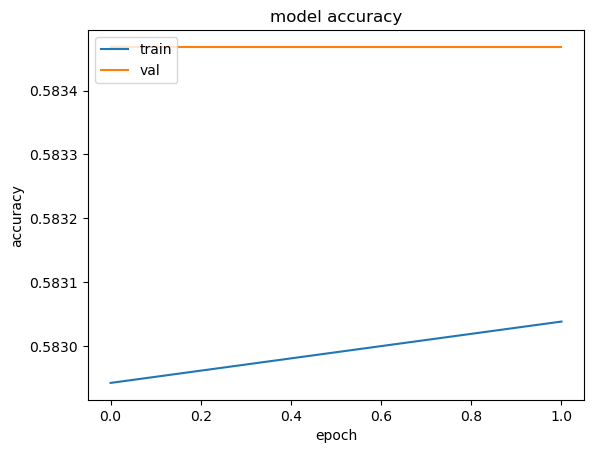

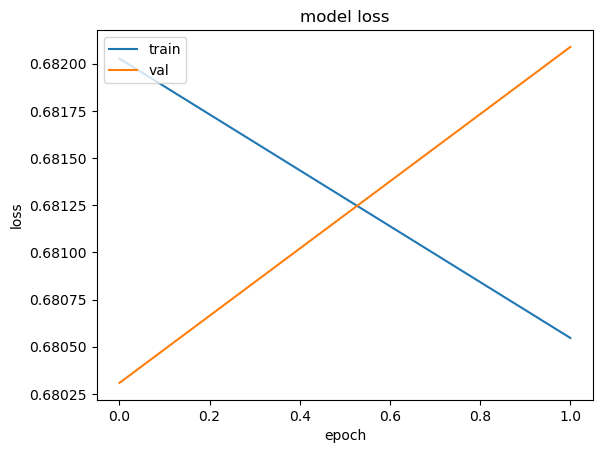

In [42]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()